In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Testing NP implementation on 1D functions sampled from a Gaussian Process

Adapted from https://github.com/EmilienDupont/neural-processes example-1d.ipynb

### Visualize Data

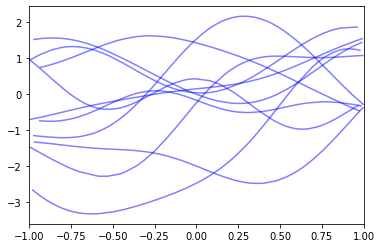

In [2]:
from datasets import GPData, SineData
from math import pi

# Create dataset
dataset = GPData(lengthscale_range=(0.5, 0.5),
                   noise_range=(1., 1.),
                   num_samples=2000,
                   num_points=100)

# dataset = SineData(amplitude_range=(-1., 1.),
#                    shift_range=(-.5, .5),
#                    num_samples=2000)

# Visualize data samples
for i in range(10):
    x, y = dataset[i] 
    plt.plot(x.squeeze(), y.squeeze(), c='b', alpha=0.5)
    plt.xlim(-1, 1)
    # plt.xlim(-pi, pi)

### Build Neural Process

In [3]:
from np import SimpleNP

x_dim = 1
y_dim = 1
r_dim = 50  # Dimension of representation of context points
z_dim = 50  # Dimension of sampled latent variable
h_dim = 50  # Dimension of hidden layers in encoder and decoder
h_dim_enc = [50, 50]
h_dim_dec = [50, 50, 50]
neuralprocess = SimpleNP(x_dim=x_dim, y_dim=y_dim, r_dim=r_dim, z_dim=z_dim, h_dim=h_dim, h_dims_dec=h_dim_dec, h_dims_enc=h_dim_enc)

### Visualize samples from prior

We can visualize the prior (i.e. the output of the neural process without any context points) before training.

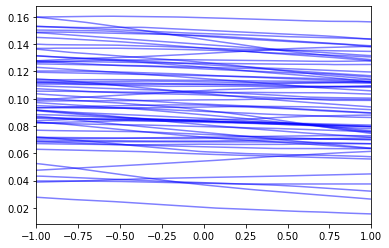

In [4]:
# Create a set of 100 target points, with shape 
# (batch_size, num_points, x_dim), which in this case is
# (1, 100, 1)
x_target = torch.Tensor(np.linspace(-1, 1, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

for i in range(64):
    z_sample = torch.randn((1, z_dim))  # Shape (batch_size, z_dim)
    # Map x_target and z to p_y_target (which is parameterized by a 
    # normal with mean mu and std dev sigma)
    mu, _ = neuralprocess.np.decoder(x_target, z_sample)
    # Plot predicted mean at each target point (note we could also
    # sample from distribution but plot mean for simplicity)
    plt.plot(x_target.numpy()[0], mu.detach().numpy()[0], 
             c='b', alpha=0.5)
    plt.xlim(-1, 1)

### Train Neural Process

In [5]:
from torch.utils.data import DataLoader
from train import train


batch_size = 2
num_context = 8
num_target = 16

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(neuralprocess.parameters(), lr=3e-4)
neuralprocess.training = True
train( device='cpu',
    neural_process = neuralprocess,
    optimizer=optimizer,
    print_freq=1,
    epochs=30,
    data_loader=data_loader,
    n_context_range=(num_context, num_context),
    n_target_range=(num_context+num_target, num_context+num_target))


  2%|▏         | 17/1000 [00:00<00:06, 160.09batch/s, loss=33.6]
Epoch 0: average loss per batch 29.471298002243042

  2%|▏         | 16/1000 [00:00<00:06, 157.27batch/s, loss=30]  
Epoch 1: average loss per batch 25.511579071998597

  2%|▏         | 16/1000 [00:00<00:06, 158.37batch/s, loss=20.3]
Epoch 2: average loss per batch 24.598078308582306

  2%|▏         | 16/1000 [00:00<00:06, 158.29batch/s, loss=38.1]
Epoch 3: average loss per batch 24.338982820987702

  2%|▏         | 16/1000 [00:00<00:06, 158.92batch/s, loss=26.2]
Epoch 4: average loss per batch 24.229037798285486

  2%|▏         | 16/1000 [00:00<00:06, 155.77batch/s, loss=21.9]
Epoch 5: average loss per batch 23.898535106658937

  2%|▏         | 16/1000 [00:00<00:06, 159.81batch/s, loss=19.6]
Epoch 6: average loss per batch 23.982066891670225

  2%|▏         | 16/1000 [00:00<00:06, 157.24batch/s, loss=15.7]
Epoch 7: average loss per batch 23.869290545344352

  2%|▏         | 16/1000 [00:00<00:06, 151.11batch/s, loss=25.5]

### Visualize samples from trained prior

The prior should now encode some information about the shapes of the functions.

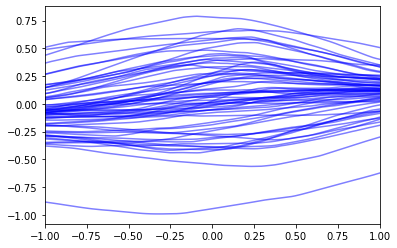

In [6]:
x_target = torch.Tensor(np.linspace(-1, 1, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

for i in range(64):
    z_sample = torch.randn((1, z_dim))
    mu, _ = neuralprocess.np.decoder(x_target, z_sample)
    plt.plot(x_target.numpy()[0], mu.detach().numpy()[0], 
             c='b', alpha=0.5)
    plt.xlim(-1, 1)

### Visualize samples from posterior

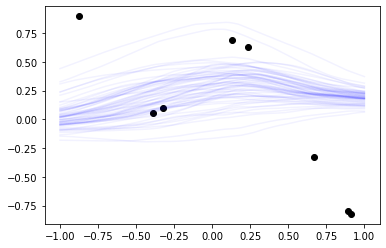

In [19]:
from train import process_data_to_points
# Extract a batch from data_loader
# Use batch to create random set of context points
x, y = next(iter(data_loader))
x_context, y_context, _, _ = process_data_to_points(x[0:1], y[0:1], 
                                                  num_context, 
                                                  num_target+num_context)

# Create a set of target points corresponding to entire [-pi, pi] range
x_target = torch.Tensor(np.linspace(-1, 1, 100))
# x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

neuralprocess.eval()

for i in range(64):
    # Neural process returns distribution over y_target
    p_y_pred, _, _ = neuralprocess(x_context.float(), y_context.float(), x_target.float(), None)
    # Extract mean of distribution
    mu = p_y_pred.loc.detach()
    plt.plot(x_target.numpy()[0], mu.numpy()[0], 
             alpha=0.05, c='b')

plt.scatter(x_context[0].numpy(), y_context[0].numpy(), c='k')

In [15]:
neuralprocess

SimpleNP(
  (np): NeuralProcess(
    (encoder): LinearEncoder(
      (to_r): Sequential(
        (0): Linear(in_features=2, out_features=50, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=50, out_features=50, bias=True)
        (3): ReLU(inplace=True)
        (4): Linear(in_features=50, out_features=50, bias=True)
      )
    )
    (decoder): LinearDecoder(
      (to_hidden): Sequential(
        (0): Linear(in_features=51, out_features=50, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=50, out_features=50, bias=True)
        (3): ReLU(inplace=True)
        (4): Linear(in_features=50, out_features=50, bias=True)
        (5): ReLU(inplace=True)
      )
      (to_mu): Linear(in_features=50, out_features=1, bias=True)
      (to_sigma): Linear(in_features=50, out_features=1, bias=True)
    )
    (combiner): MeanCombiner()
    (r_to_z_dist): LinearRToDist(
      (to_hidden): Sequential(
        (0): Linear(in_features=50, out_features=5